# Libraries

In [1]:
!pip install pandas scikit-learn xgboost matplotlib  -q


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch

from xgboost import XGBClassifier

import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from pprint import pprint

import matplotlib as plt

# Data Loading

In [3]:
path = '.'
# Combine all PDBs into a single dataframe
dfs = []
i = 0
for filename in os.listdir(os.path.join(path,'data/features_ring')):
  dfs.append(pd.read_csv(os.path.join(path, 'data/features_ring', filename), sep='\t'))
df = pd.concat(dfs)

In [4]:
df['Interaction'] = df['Interaction'].fillna('Missing')
df.dropna(inplace=True) # Remove all rows with NaN in at least one column
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,...,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,t_3di_letter,Interaction
0,1jkv,C,21,,M,H,0.000,-1.136,-0.632,-0.663,...,-1.016,-0.781,1.538,-0.055,1.502,0.440,2.897,13.0,N,VDW
1,1jkv,D,29,,L,H,0.012,-1.610,-1.068,-1.019,...,-1.848,3.038,-0.228,1.399,-4.760,0.670,-2.647,2.0,C,VDW
2,1jkv,C,112,,H,T,0.092,-1.834,-0.048,0.336,...,-2.345,2.872,0.945,0.828,1.299,-0.169,0.933,5.0,F,HBOND
3,1jkv,B,113,,G,S,0.012,1.163,0.734,-0.384,...,-1.474,1.256,0.945,0.828,1.299,-0.169,0.933,12.0,M,HBOND
4,1jkv,E,41,,S,H,0.000,-1.150,-0.898,-0.228,...,-1.115,-0.714,0.931,-0.179,-3.005,-0.503,-1.853,13.0,N,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,9o8y,A,195,,V,-,0.000,-0.966,2.484,-1.337,...,-2.228,-3.048,-0.228,1.399,-4.760,0.670,-2.647,2.0,C,Missing
1310,9o8y,B,90,,K,S,0.049,-1.272,-0.647,1.831,...,-1.723,2.453,-0.591,-1.302,-0.733,1.570,-0.146,6.0,G,HBOND
1311,9o8y,A,76,,M,E,0.181,-2.590,2.566,-0.663,...,-2.300,2.976,-1.006,-0.590,1.891,-0.397,0.412,2.0,C,HBOND
1312,9o8y,A,76,,M,E,0.181,-2.590,2.566,-0.663,...,-2.300,2.976,-1.006,-0.590,1.891,-0.397,0.412,2.0,C,VDW


# Data preprocessing

## Interaction Ranking

In [5]:
df = df[df['Interaction'] != 'VDW']

interaction_priority = {
    'SSBOND' : 0,
    'IONIC' : 1,
    'HBOND' : 2,
    'PIPISTACK' : 3,
    'PICATION' : 4,
    'PIHBOND' : 5,
    'VDW' : 6,
    'Missing' : 7,
}

df['Interaction_rank'] = df['Interaction'].map(interaction_priority)

cols_features = [c for c in df.columns if c not in ['Interaction', 'Interaction_rank']]
df = df.sort_values(by=['pdb_id', 'Interaction_rank'], ascending=[True, True])
df = df.drop_duplicates(subset=cols_features, keep='first')

df = df.drop(columns=['Interaction_rank'])

/tmp/ipykernel_1539/3283039130.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Interaction_rank'] = df['Interaction'].map(interaction_priority)


## Feature engineering

In [6]:
df["c_dist"] = np.where(
    df["s_ch"] == df["t_ch"],
    (df["s_resi"] - df["t_resi"]).abs(),
    -1
)
df["c_is_same_chain"] = df["s_ch"] == df["t_ch"]
df.drop(['s_resi', 't_resi'], axis=1, inplace=True)
df

,pdb_id,s_ch,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,s_a2,...,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,t_3di_letter,Interaction,c_dist,c_is_same_chain
79,50000000000000.0,A,,C,H,0.074,-0.971,-0.408,-1.343,0.465,...,-1.343,0.465,-0.862,-1.020,-0.255,8.0,I,SSBOND,56,True
98,50000000000000.0,A,,C,B,0.044,-1.274,2.187,-1.343,0.465,...,-1.343,0.465,-0.862,-1.020,-0.255,8.0,I,SSBOND,9,True
138,50000000000000.0,A,,C,H,0.000,-0.996,-0.780,-1.343,0.465,...,-1.343,0.465,-0.862,-1.020,-0.255,18.0,S,SSBOND,60,True
139,50000000000000.0,A,,C,-,0.126,-1.346,1.994,-1.343,0.465,...,-1.343,0.465,-0.862,-1.020,-0.255,16.0,Q,SSBOND,59,True
0,50000000000000.0,A,,W,H,0.661,-1.056,-0.634,-0.595,0.009,...,-1.006,-0.590,1.891,-0.397,0.412,1.0,B,HBOND,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,9o8y,A,,G,-,0.131,-1.299,2.538,-0.384,1.652,...,-0.032,0.326,2.213,0.908,1.313,3.0,D,Missing,11,True
1303,9o8y,B,,L,H,0.030,-1.096,-0.769,-1.019,-0.987,...,-0.384,1.652,1.330,1.045,2.064,13.0,N,Missing,76,True
1305,9o8y,B,,V,E,0.028,-2.387,2.475,-1.337,-0.279,...,0.260,0.830,3.097,-0.838,1.512,19.0,T,Missing,17,True
1309,9o8y,A,,V,-,0.000,-0.966,2.484,-1.337,-0.279,...,-0.228,1.399,-4.760,0.670,-2.647,2.0,C,Missing,15,True


In [7]:
df[df["c_is_same_chain"] == False]

,pdb_id,s_ch,s_ins,s_resn,s_ss8,s_rsa,s_phi,s_psi,s_a1,s_a2,...,t_a1,t_a2,t_a3,t_a4,t_a5,t_3di_state,t_3di_letter,Interaction,c_dist,c_is_same_chain
930,4000000000000000.0,A,,E,-,0.366,-1.687,1.571,1.357,-1.453,...,1.831,-0.561,0.533,-0.277,1.648,11.0,L,IONIC,-1,False
313,4000000000000000.0,A,,R,H,0.153,-1.142,-0.728,1.538,-0.055,...,-0.384,1.652,1.330,1.045,2.064,12.0,M,HBOND,-1,False
239,4000000000000000.0,A,,M,G,0.000,-1.008,-0.484,-0.663,-1.524,...,0.945,0.828,1.299,-0.169,0.933,17.0,R,Missing,-1,False
829,4000000000000000.0,A,,K,H,0.415,-0.987,-0.641,1.831,-0.561,...,1.831,-0.561,0.533,-0.277,1.648,9.0,J,Missing,-1,False
491,10000000000000000000.0,A,,K,H,0.444,-1.222,-0.406,1.831,-0.561,...,1.357,-1.453,1.477,0.113,-0.837,2.0,C,IONIC,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,9o8y,B,,P,T,0.103,-1.289,-0.067,0.189,2.081,...,-0.032,0.326,2.213,0.908,1.313,18.0,S,Missing,-1,False
1226,9o8y,A,,M,T,0.133,-1.079,2.540,-0.663,-1.524,...,1.357,-1.453,1.477,0.113,-0.837,19.0,T,Missing,-1,False
1256,9o8y,A,,G,E,0.071,-2.686,-2.727,-0.384,1.652,...,-0.228,1.399,-4.760,0.670,-2.647,16.0,Q,Missing,-1,False
1287,9o8y,B,,Q,E,0.066,-1.964,2.269,0.931,-0.179,...,-1.006,-0.590,1.891,-0.397,0.412,1.0,B,Missing,-1,False


## Splitting in data and labels

In [8]:
columns = [
  'c_dist',
  'c_is_same_chain',
  's_ss8',
  's_rsa',
  's_phi',
  's_psi',
  's_a1',
  's_a2',
  's_a3',
  's_a4',
  's_a5',
  's_3di_state',
  't_ss8',
  't_rsa',
  't_phi',
  't_psi',
  't_a1',
  't_a2',
  't_a3',
  't_a4',
  't_a5',
  't_3di_state',
]

X = df[columns]
X
y = df['Interaction'].astype('category')

## One-Hot encoding for categorical cols

In [9]:
cat_cols = [c for c, t in X.dtypes.items() if t == 'object' or t.name == 'category']
print("Object/categorical columns:", cat_cols)

Object/categorical columns: ['s_ss8', 't_ss8']


In [10]:
X = pd.get_dummies(X, columns=cat_cols, prefix=cat_cols, drop_first=False)
X

,c_dist,c_is_same_chain,s_rsa,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,...,s_ss8_T,t_ss8_-,t_ss8_B,t_ss8_E,t_ss8_G,t_ss8_H,t_ss8_I,t_ss8_P,t_ss8_S,t_ss8_T
79,56,True,0.074,-0.971,-0.408,-1.343,0.465,-0.862,-1.020,-0.255,...,False,False,False,True,False,False,False,False,False,False
98,9,True,0.044,-1.274,2.187,-1.343,0.465,-0.862,-1.020,-0.255,...,False,False,False,True,False,False,False,False,False,False
138,60,True,0.000,-0.996,-0.780,-1.343,0.465,-0.862,-1.020,-0.255,...,False,False,False,True,False,False,False,False,False,False
139,59,True,0.126,-1.346,1.994,-1.343,0.465,-0.862,-1.020,-0.255,...,False,True,False,False,False,False,False,False,False,False
0,4,True,0.661,-1.056,-0.634,-0.595,0.009,0.672,-2.128,-0.184,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,11,True,0.131,-1.299,2.538,-0.384,1.652,1.330,1.045,2.064,...,False,False,False,False,False,False,False,True,False,False
1303,76,True,0.030,-1.096,-0.769,-1.019,-0.987,-1.505,1.266,-0.912,...,False,False,False,False,False,False,False,False,False,True
1305,17,True,0.028,-2.387,2.475,-1.337,-0.279,-0.544,1.242,-1.262,...,False,False,False,True,False,False,False,False,False,False
1309,15,True,0.000,-0.966,2.484,-1.337,-0.279,-0.544,1.242,-1.262,...,False,True,False,False,False,False,False,False,False,False


In [11]:
list(X.columns)

['c_dist',
 'c_is_same_chain',
 's_rsa',
 's_phi',
 's_psi',
 's_a1',
 's_a2',
 's_a3',
 's_a4',
 's_a5',
 's_3di_state',
 't_rsa',
 't_phi',
 't_psi',
 't_a1',
 't_a2',
 't_a3',
 't_a4',
 't_a5',
 't_3di_state',
 's_ss8_-',
 's_ss8_B',
 's_ss8_E',
 's_ss8_G',
 's_ss8_H',
 's_ss8_I',
 's_ss8_P',
 's_ss8_S',
 's_ss8_T',
 't_ss8_-',
 't_ss8_B',
 't_ss8_E',
 't_ss8_G',
 't_ss8_H',
 't_ss8_I',
 't_ss8_P',
 't_ss8_S',
 't_ss8_T']

# Train/Test splitting

In [12]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1) 

print(y_train.value_counts())
print(y_test.value_counts())
print(y_val.value_counts())
print("----------------")
print(y_train_full.value_counts())

Interaction
Missing      636928
HBOND        597767
IONIC         20600
PIPISTACK     16311
PICATION       3876
SSBOND         1163
PIHBOND         446
Name: count, dtype: int64
Interaction
Missing      212256
HBOND        199095
IONIC          6904
PIPISTACK      5550
PICATION       1309
SSBOND          426
PIHBOND         158
Name: count, dtype: int64
Interaction
Missing      212808
HBOND        198819
IONIC          6802
PIPISTACK      5430
PICATION       1284
SSBOND          429
PIHBOND         126
Name: count, dtype: int64
----------------
Interaction
Missing      849736
HBOND        796586
IONIC         27402
PIPISTACK     21741
PICATION       5160
SSBOND         1592
PIHBOND         572
Name: count, dtype: int64


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X_val  = scaler.transform(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

# Metrics

In [14]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    log_loss,
    cohen_kappa_score,
    matthews_corrcoef,
    roc_auc_score,
    balanced_accuracy_score,
    average_precision_score
)

def evaluate_multiclass(y_true, y_pred, y_prob=None, labels=None):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    for avg in ('micro', 'macro', 'weighted'):
        metrics[f'precision_{avg}'] = precision_score(y_true, y_pred, average=avg, zero_division=0)
        metrics[f'recall_{avg}']    = recall_score(y_true, y_pred, average=avg, zero_division=0)
        metrics[f'f1_{avg}']        = f1_score(y_true, y_pred, average=avg, zero_division=0)

    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    if y_prob is not None:
        metrics['log_loss'] = log_loss(y_true, y_prob, labels=labels)
        metrics['roc_auc_ovr']   = roc_auc_score(y_true, y_prob, multi_class='ovr', labels=labels)
        metrics['roc_auc_ovo']   = roc_auc_score(y_true, y_prob, multi_class='ovo', labels=labels)
        metrics['roc_auc_macro'] = roc_auc_score(
            y_true, y_prob,
            multi_class='ovr',
            average='macro',
            labels=labels
        )

        for avg in ('micro', 'macro', 'weighted'):
            metrics[f'average_precision_{avg}'] = average_precision_score(
                y_true, y_prob,
                average=avg
            )

    metrics['cohen_kappa']   = cohen_kappa_score(y_true, y_pred)
    metrics['matthews_corr'] = matthews_corrcoef(y_true, y_pred)

    return metrics

# Basic XGBOOST

In [15]:
xgbn = XGBClassifier(eval_metric='logloss')
xgbn.fit(np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0))

y_pred_xgbn = xgbn.predict(X_test)
y_prob_xgbn = xgbn.predict_proba(X_test)

Basic XGBoost Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    199095
           1       0.58      0.46      0.51      6904
           2       0.78      0.82      0.80    212256
           3       0.53      0.11      0.18      1309
           4       1.00      0.07      0.13       158
           5       0.62      0.82      0.70      5550
           6       0.81      0.94      0.87       426

    accuracy                           0.78    425698
   macro avg       0.73      0.57      0.57    425698
weighted avg       0.78      0.78      0.78    425698

Metrics Report:
{'accuracy': 0.7808751744194241,
 'average_precision_macro': 0.6440361010658597,
 'average_precision_micro': 0.8736611454808322,
 'average_precision_weighted': 0.869431274717622,
 'balanced_accuracy': 0.566835525645347,
 'cohen_kappa': 0.5870406165257707,
 'f1_macro': 0.566846041840759,
 'f1_micro': 0.7808751744194241,
 'f1_weighted': 0.7

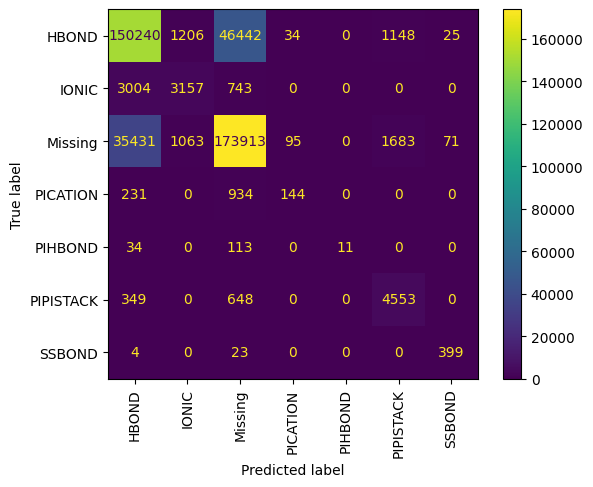

In [16]:
print("Basic XGBoost Results:")

cm = confusion_matrix(y_test, y_pred_xgbn) #, normalize='true')
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plot.plot(xticks_rotation='vertical')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgbn))

print("Metrics Report:")
pprint(evaluate_multiclass(y_test, y_pred_xgbn, y_prob=y_prob_xgbn))

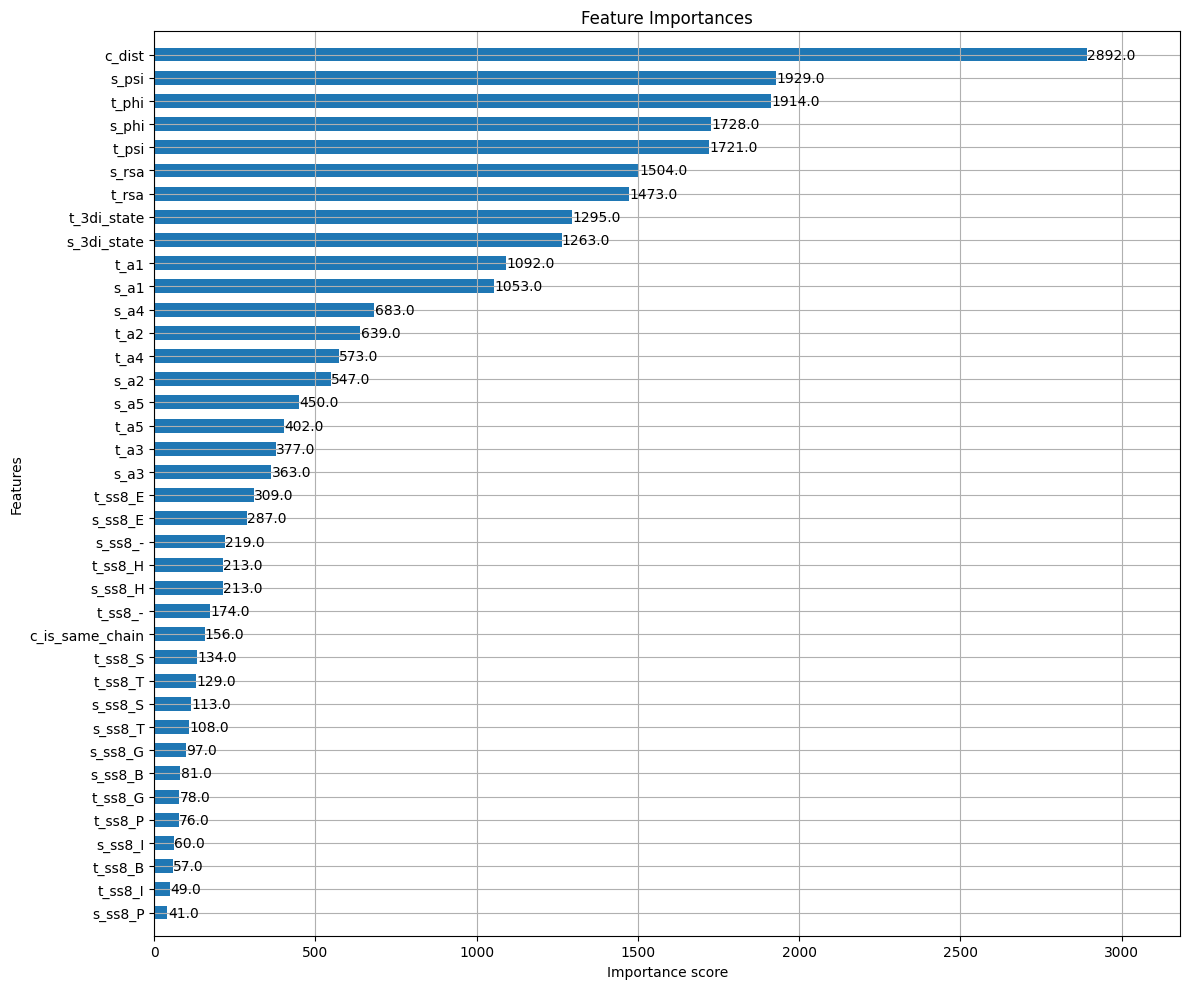

In [17]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

xgbn.get_booster().feature_names = list(X.columns)
fig, ax = plt.subplots(figsize=(12, 10))
plot_importance(xgbn, height=0.6, ax=ax)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Advanced XGBOOST

In [18]:
import xgboost as xgb

In [19]:
base = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    device = "cuda",
    n_jobs=-1,
    random_state=42
)

In [20]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = {
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'max_depth':        [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'gamma':            [0, 0.1, 0.2, 0.5],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.01, 0.1, 1],
    'reg_lambda':       [1, 1.5, 2, 3]
}

search = RandomizedSearchCV(base, grid, n_iter=50,
                            scoring='neg_log_loss',
                            cv=cv, n_jobs=-1, random_state=42)

In [21]:
search.fit(X_train, y_train)
best_params = search.best_params_

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:729: UserWarning: [13:12:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:729: UserWarning: [13:12:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before

In [22]:
X_full = np.vstack([X_train, X_val])
y_full = np.concatenate([y_train, y_val])
dtrain = xgb.DMatrix(X_full, label=y_full)

cvres = xgb.cv(
    { 'objective':'multi:softprob',
      'num_class':len(np.unique(y_full)),
      'eval_metric':'mlogloss',
      **best_params },
    dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=30,
    as_pandas=True,
    seed=42
)
best_n = len(cvres)

In [23]:
final = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42,
    n_estimators=best_n,
    **best_params
)
final.fit(X_full, y_full)

/usr/local/lib/python3.10/dist-packages/xgboost/training.py:183: UserWarning: [13:43:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [24]:
import joblib
joblib.dump(final, 'model_weights.joblib')
final.save_model('model_weights.json')

In [25]:
best_params

{'subsample': 1.0,
 'reg_lambda': 1,
 'reg_alpha': 0.01,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.8}

In [26]:
y_pred_xgb = final.predict(X_test)
y_prob_xgb = final.predict_proba(X_test)

Advanced XGBoost Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    199095
           1       0.66      0.59      0.62      6904
           2       0.82      0.84      0.83    212256
           3       0.71      0.37      0.49      1309
           4       0.84      0.24      0.37       158
           5       0.73      0.82      0.77      5550
           6       0.85      0.89      0.87       426

    accuracy                           0.82    425698
   macro avg       0.78      0.65      0.68    425698
weighted avg       0.82      0.82      0.82    425698

Metrics Report:
{'accuracy': 0.820865966013465,
 'average_precision_macro': 0.7385428349618135,
 'average_precision_micro': 0.9057760058567818,
 'average_precision_weighted': 0.9030424333901811,
 'balanced_accuracy': 0.6521741812911875,
 'cohen_kappa': 0.6626832835089695,
 'f1_macro': 0.6826970275409954,
 'f1_micro': 0.820865966013465,
 'f1_weighted':

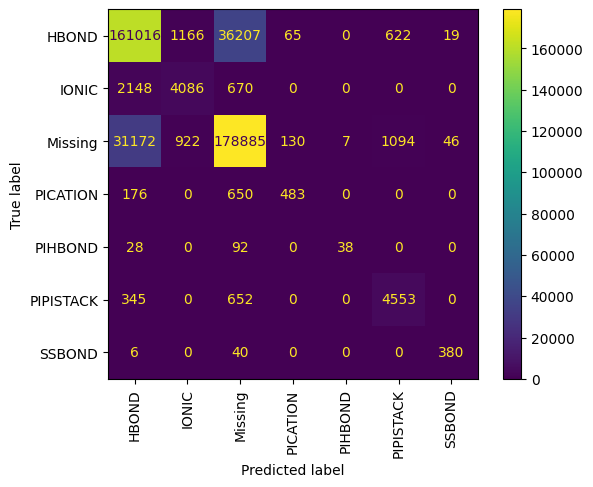

In [27]:
print("Advanced XGBoost Results:")

cm = confusion_matrix(y_test, y_pred_xgb) #, normalize='true')
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plot.plot(xticks_rotation='vertical')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Metrics Report:")
pprint(evaluate_multiclass(y_test, y_pred_xgb, y_prob=y_prob_xgb))